Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# This notebook creates the training script and runs it. It tests the model locally

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Experiment

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Azure ML SDK Version:  1.0.55


In [2]:
project_folder=os.getcwd()
data_folder='trainDataset'
script_folder='scripts' 
os.makedirs(script_folder, exist_ok=True)

### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`. Here we also create the object pointing to the default datastore 'ds'

In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

AzureBlob demoimages1077181835 azureml-blobstore-72619590-248c-45bf-a2cd-0413350c2ab4
DemoImages	northeurope	LufthansaZeroG	northeurope


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [4]:
experiment_name = 'ImageClassifier'
experiment = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [5]:
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


### Upload data to the cloud

In [6]:
ds.upload(src_dir=data_folder, target_path='trainDataset', overwrite=True, show_progress=True)
ds.upload(src_dir=data_folder, target_path='testDataset', overwrite=True, show_progress=True)

Uploading an estimated of 5 files
Uploading trainDataset/encoder
Uploading trainDataset/x_train.tsv
Uploading trainDataset/x_val.tsv
Uploading trainDataset/y_train.tsv
Uploading trainDataset/y_val.tsv
Uploaded trainDataset/encoder, 1 files out of an estimated total of 5
Uploaded trainDataset/y_train.tsv, 2 files out of an estimated total of 5
Uploaded trainDataset/y_val.tsv, 3 files out of an estimated total of 5
Uploaded trainDataset/x_val.tsv, 4 files out of an estimated total of 5
Uploaded trainDataset/x_train.tsv, 5 files out of an estimated total of 5
Uploaded 5 files
Uploading an estimated of 5 files
Uploading trainDataset/encoder
Uploading trainDataset/x_train.tsv
Uploading trainDataset/x_val.tsv
Uploading trainDataset/y_train.tsv
Uploading trainDataset/y_val.tsv
Uploaded trainDataset/encoder, 1 files out of an estimated total of 5
Uploaded trainDataset/y_train.tsv, 2 files out of an estimated total of 5
Uploaded trainDataset/y_val.tsv, 3 files out of an estimated total of 5
Upl

$AZUREML_DATAREFERENCE_f4be63efbce94a5f87ff1a833acbc904

### Preparation for the model

In [11]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
ntrain=len(x_train)
nval=len(x_val)
batch_size=32

In [12]:
%%writefile $script_folder/train.py
import argparse
import os
import numpy as np
import pickle
#from azureml.core.run import Run
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch_size', type=int, dest='batch_size', help='batch_size')
parser.add_argument('--layer_size', type=int, dest='layer_size', help='layer size multiplier')

args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)
batch_size = int(args.batch_size)
print('Batch size:', batch_size)
layer_size = int(args.layer_size)
print('Layer size:', layer_size)


with open(os.path.join(data_folder, 'x_train.tsv'),"rb") as f:
    x_train = pickle.load(f)
with open(os.path.join(data_folder,'y_train.tsv'),"rb") as f:
    y_train = pickle.load(f)
with open(os.path.join(data_folder,'x_val.tsv'),"rb") as f:
    x_val = pickle.load(f)
with open(os.path.join(data_folder,'y_val.tsv'),"rb") as f:
    y_val = pickle.load(f)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, sep = '\n')

ntrain=len(x_train)
nval=len(x_val)


###################  modeling part

model=models.Sequential()
model.add(layers.Conv2D(32*layer_size,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128*layer_size,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512*layer_size,activation='relu'))
model.add(layers.Dense(8,activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

trainDataGen= ImageDataGenerator(
                    rescale=1.,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2
                    )
valDataGen=ImageDataGenerator(rescale=1.)

trainGenerator=trainDataGen.flow(x_train,y_train,batch_size = batch_size)
valGenerator=valDataGen.flow(x_val,y_val,batch_size = batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history=model.fit_generator(trainGenerator,
                            steps_per_epoch = ntrain//batch_size,
                            epochs = 32,
                            validation_data = valGenerator,
                            validation_steps = nval//batch_size,
                            callbacks=[early_stopping],
                            workers=3
                           )

# for now I am not using the output argument from the args
os.makedirs('./outputs/model', exist_ok=True)

# serialize NN architecture to JSON
model_json = model.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

with open('./outputs/model/trainHistoryDict', 'wb') as f:
        pickle.dump(history.history, f)



Overwriting scripts/train.py


#### The snapshot will contain all files in the project folder except the ones in the file '.amlignore'. 
The total snapshot size can't be larger than 300Mb and so we exclude largert files and folders

In [13]:
%%writefile $project_folder/.amlignore
data
model
sourceData
Training
Testing
trainDataset
testDataset
dataLH
model_keras.h5
model_weights.h5
model_wieghts.h5
ARCH

Overwriting /mnt/azmnt/code/Users/.amlignore


## Run the training job 

#### Create an estimator 

An estimator object is used to submit the run. Azure Machine Learning has pre-configured estimators for common machine learning frameworks, as well as generic Estimator. Create TensorFlow estimator specifying:

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore (`ds.path('trainDataset').as_mount()`). We populated it above by uploading the data to it.

In [16]:
from azureml.train.dnn import TensorFlow
from azureml.core.runconfig import MpiConfiguration

script_params = {
    '--data-folder': ds.path('trainDataset').as_mount(),
    '--batch_size': 16,
    '--layer_size': 2 # multiplier for the layer
    
}

est = TensorFlow(source_directory=script_folder,
                 entry_script='train.py',
                 script_params=script_params,
                 compute_target=compute_target,
                 pip_packages=['keras', 'matplotlib','sklearn'],
                 node_count=4,
                 process_count_per_node=1,
                 distributed_training=MpiConfiguration(),
                 framework_version="1.13", 
                 use_gpu=True)

#### Submit the job to the cluster

In [17]:
run = experiment.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifier,ImageClassifier_1567503286_0fbd5f42,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


#### Monitor a remote run


In [18]:
from azureml.widgets import RunDetails
RunDetails(run).show()


A Jupyter Widget

In [19]:
print(compute_target.get_status().current_node_count)
print(compute_target.get_status().allocation_state)

3
Steady


#### (Optional) you can download older run

In [20]:
from azureml.core import Run
 
run_id='ImageClassifier_1566901801_b3bd90fc'
Run(experiment, run_id)

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifier,ImageClassifier_1566901801_b3bd90fc,azureml.scriptrun,Completed,Link to Azure Portal,Link to Documentation


#### Artefacts from /output folder are uploaded to the Workspace

In [21]:
print(run.get_file_names())

[]


#### Download the model

In [22]:
# Create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

In [23]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Loaded model from disk")


W0903 09:34:57.090050 139792193132288 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 09:34:57.109346 139792193132288 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 09:34:57.125618 139792193132288 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0903 09:34:57.187511 139792193132288 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_gr

Loaded model from disk


In [24]:
from keras import layers, models, optimizers
loaded_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])


W0903 09:35:00.647305 139792193132288 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [25]:
with open('model/trainHistoryDict',"rb") as f:
     history=pickle.load(f)

### Visualize

In [26]:
acc=history['acc']
val_acc=history['val_acc']
loss=history['loss']
val_loss=history['val_loss']
epochs = range(len(acc))

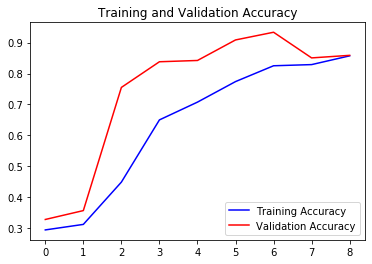

In [27]:
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend( loc="lower right")
plt.title('Training and Validation Accuracy')
plt.show()

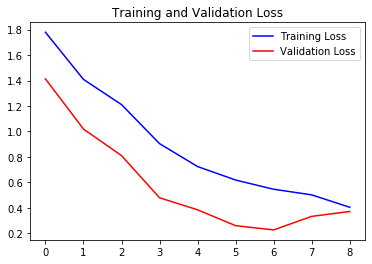

In [28]:
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend( loc="upper right")
plt.title('Training and Validation Loss')
plt.show()

### Test locally

In [29]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "y_train.tsv"),"rb") as f:
     y_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
with open(os.path.join('trainDataset', "y_val.tsv"),"rb") as f:
     y_val=pickle.load(f)
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)

In [30]:
predicted=loaded_model.predict(x_test)
pred=[]
for p in predicted:
   # pred.append((p//np.amax(p)).astype(int))
    pred.append(np.argmax(p))
labelsText = encoder.inverse_transform(np.array(pred))

In [31]:
sep=np.repeat('/',len(labelsText))
labelsValid=np.core.defchararray.add(np.core.defchararray.add(labelsText,sep),y_test)

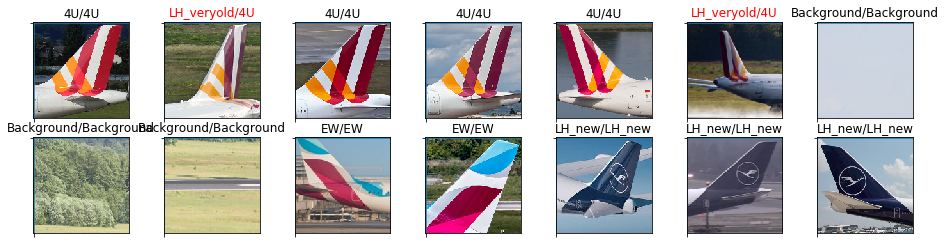

In [32]:
i=0
plt.figure(figsize = (16,6))

for p in range(len(predicted)):    
    imgData=x_test[p]
    
    plt.subplot(3, len(labelsText)//2, p+1)
    plt.axhline('')
    plt.axvline('')
    plt.imshow(imgData, cmap=plt.cm.Greys)
    title_obj=plt.title(labelsValid[p], fontsize=12)
    if (labelsText[p]!=y_test[p]):
        plt.setp(title_obj, color='r')         #set the color of title to red   
plt.show()

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)

### Register the model
When the results of the model are satisfactory we can register it in Model Registry giving it a name and pointing to the folder where the model object is located 

In [34]:
# register model
model = run.register_model(model_name='LHdemo',
                           model_path='outputs/model')
print(model.name, model.id, model.version, sep='\t')


LHdemo	LHdemo:13	13


#### Display registered models with versions

In [35]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: LHdemo 	Version: 13 	Description: None {}
Name: onnxmodel 	Version: 4 	Description: None {}
Name: mnist 	Version: 2 	Description: None {}


#### Or retrieve an older registered model 

In [36]:
from azureml.core.model import Model
import os

older_model = Model(workspace=ws, name="LHdemo", version=4)
older_model.download(target_dir=os.getcwd(),exist_ok=True)
older_model

Model(workspace=Workspace.create(name='DemoImages', subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b', resource_group='LufthansaZeroG'), name=LHdemo, id=LHdemo:4, version=4, tags={}, properties={})

# Next step
In the next chapter we will create simple deployment of the model usint Azure ML Service 